In [1]:
import numpy as np
import pandas
import pm4py
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
from sklearn.model_selection import train_test_split

pandas.set_option('display.max_rows', 10000)

In [2]:
n = 100
data = pandas.DataFrame.from_dict({
        'after_noon' : [0]*n + [1]*n + [2]*n + [3]*n,
        'processing_time' : 
            list(
                np.where(np.random.choice(a=[0, 1], size=n, p=[0.5, 0.5]),
                         np.random.normal(2.2, 0.2, n),
                         np.random.normal(6, 0.2, n)
                )
            ) + list(
                np.random.normal(2, 0.2, n)
            )
             + 2*list(
                        np.random.normal(4, 0.2, n)
                    )
})

In [3]:
train, test = train_test_split(data, test_size=0.2)

In [4]:
train

,after_noon,processing_time
374,3,3.811507
0,0,2.085756
176,1,2.103473
346,3,4.033192
394,3,4.032123
283,2,3.955746
216,2,3.985988
291,2,4.098994
116,1,1.906205
146,1,2.326405


<Axes: >

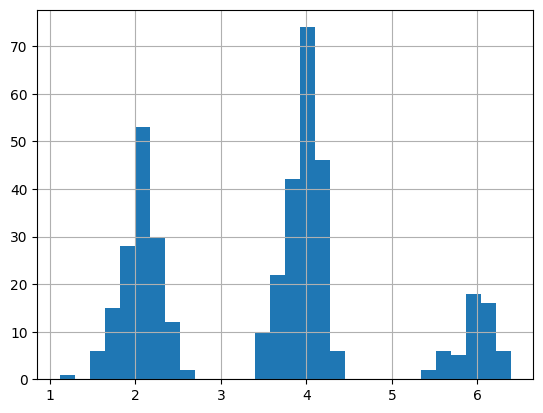

In [5]:
data['processing_time'].hist(bins=30)

In [6]:
class GMM:
    def __init__(self, start_end_event_log, n=10, percentile=False):
        self.durations = start_end_event_log['processing_time'].to_numpy()
        self._get_x(start_end_event_log, percentile)
        self.gmm = self.get_gmm(self.x, n)

    def _get_x(self, durations, percentile):
        if percentile:
            self.durations = self.durations[self.durations <= np.percentile(self.durations, percentile)]
        self.x = np.ravel(self.durations).astype(np.float64).reshape(-1,1)
    
    def get_gmm(self, x, n):
        mm = GaussianMixture(n,
                             covariance_type='full',
                             n_init=1000,
                             #covariance_type='spherical',
                             init_params='k-means++',
                             #init_params='kmeans',
                             #init_params='random_from_data',
                             #init_params='random',
                             max_iter=1000
                            )
        mm.fit(x)
        return mm

    def get_pdf_values(self, f_axis):
        X = np.ravel(f_axis).astype(np.float64).reshape(-1,1)
        pdf = lambda x : sum([weight * stats.norm.pdf(x, mean, np.sqrt(cov))[0] \
                              for weight, mean, cov in zip(self.gmm.weights_, self.gmm.means_, self.gmm.covariances_)])
        return np.array([pdf(x) for x in X]).flatten()

    def goodness(self):
        #predictions = self.get_pdf_values(self.x)
        #gmm_samples, _ = self.gmm.sample(100000)
        #data_hist_weights, data_hist_bins = np.histogram(self.x, bins=min(200, int(len(self.x))), density=False)
        #sample_hist_weights, sample_hist_bins  = np.histogram(gmm_samples, bins=min(200, int(len(self.x))), density=False)

        #bins_2_values = lambda bins : [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
        #data_hist_values, sample_hist_values = bins_2_values(data_hist_bins), bins_2_values(sample_hist_bins)
        #wd_hist = stats.wasserstein_distance(data_hist_values, sample_hist_values, data_hist_weights, sample_hist_weights)
        times_enlargen = int(100000 / len(self.x))
        if times_enlargen:
            augmented_x = np.array([])
            for i in range(times_enlargen):
                augmented_x = np.append(augmented_x, np.ravel(self.x))
            wd_x = stats.wasserstein_distance(augmented_x, self.gmm.sample(len(augmented_x))[0].ravel())
        else:
            wd_x = stats.wasserstein_distance(np.ravel(self.x), self.gmm.sample(len(self.x))[0].ravel())
        #wd_pdf = stats.wasserstein_distance(np.ravel(self.x), np.ravel(self.x), predictions, np.ones(self.x.shape))
        bic = self.gmm.bic(self.x)
        #return bic
        #aic = self.gmm.aic(self.x)
        #return ot.wasserstein_1d(np.ravel(self.x), np.ravel(self.x), predictions)
        return wd_x, bic#, wd_hist, wd_pdf, bic, aic
    
    def plot_gmm(self, other_gmm=None, show_all=True, percentile=False):
        # remove outliers
        if percentile:
            pruned_durations = self.durations[self.durations <= np.percentile(self.durations, percentile)]
        else:
            pruned_durations = self.durations
        f_axis = np.linspace(max(0, pruned_durations.min()-10), pruned_durations.max(), 10000)
        predictions = self.get_pdf_values(f_axis)
        plt.plot(f_axis, predictions)
        
        gmm_samples, _ = self.gmm.sample(100000)
        plt.hist(gmm_samples, bins=min(200, int(len(self.x))), histtype='bar', density=True, alpha=0.5, range=(pruned_durations.min(), pruned_durations.max()))
        #predictions = np.exp(self.gmm.score_samples(np.ravel(f_axis).astype(np.float64).reshape(-1,1)))
        #plt.plot(f_axis, predictions)
        if show_all:
            _, bins, patches = plt.hist(self.x, bins=min(200, int(len(self.x))), histtype='bar', density=True, alpha=0.5, range=(pruned_durations.min(), pruned_durations.max()))
            max_height = max([i.get_height() for i in patches])
            plt.ylim(0, max_height*1.1)
            for i in range(len(self.gmm.weights_)):
                plt.plot(f_axis,self.gmm.weights_[i]*stats.norm.pdf(f_axis,self.gmm.means_[i],np.sqrt(self.gmm.covariances_[i])).ravel(),
                        linestyle='dashed')

            plt.scatter(self.gmm.means_, [0]*len(self.gmm.means_), marker='o', color='red') 
            
            plt.rcParams['agg.path.chunksize'] = 10000
            plt.grid()

        if other_gmm:
            plt.plot(f_axis, other_gmm.get_pdf_values(f_axis))
        plt.show()

1


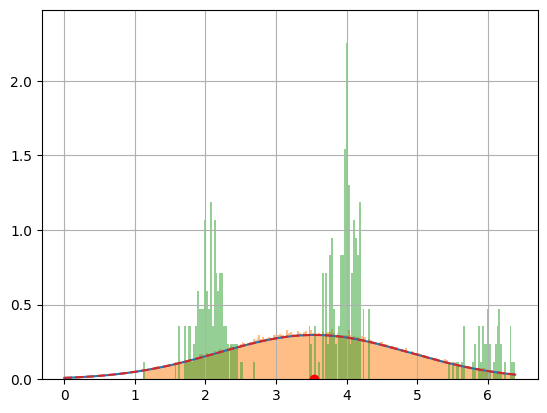

(0.37666960897851265, 1108.2915325920321)
---
2


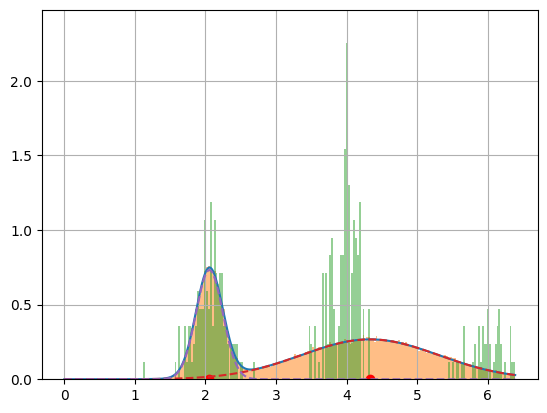

(0.24706956832080798, 925.514118417196)
---
3


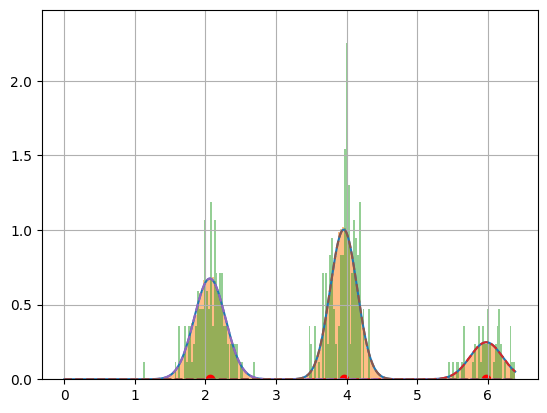

(0.028060869935670262, 587.8916781222711)
---
4


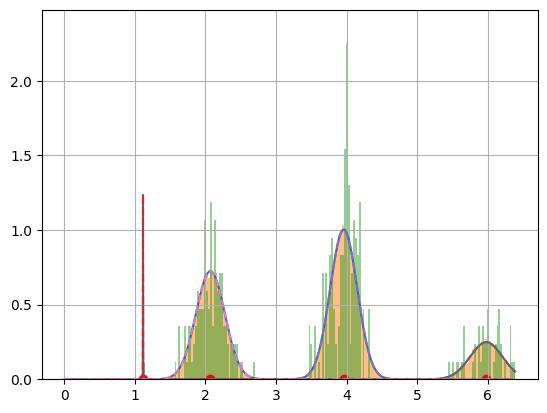

(0.024334256809792152, 586.1419249679946)
---


In [7]:
for i in range(1,5):
    print(i)
    gmm = GMM(train, i)
    gmm.plot_gmm()
    print(gmm.goodness())
    print('---')

1


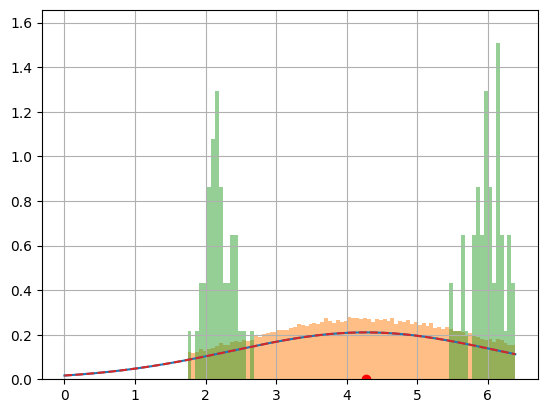

(0.8775568053525401, 354.7918231094324)
---
2


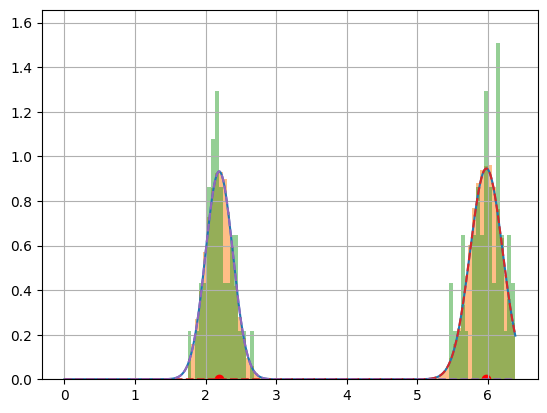

(0.02875115911892434, 116.64590854933198)
---
3


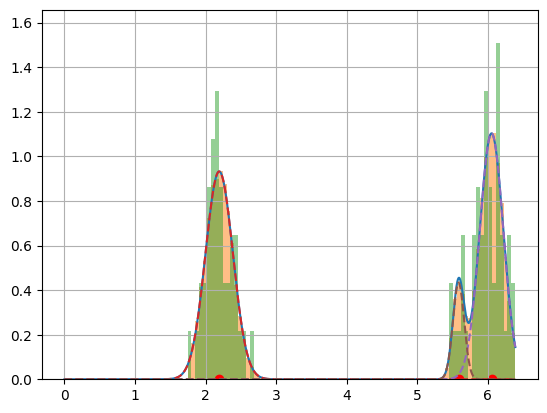

(0.025306331073109055, 123.87851380937795)
---
4


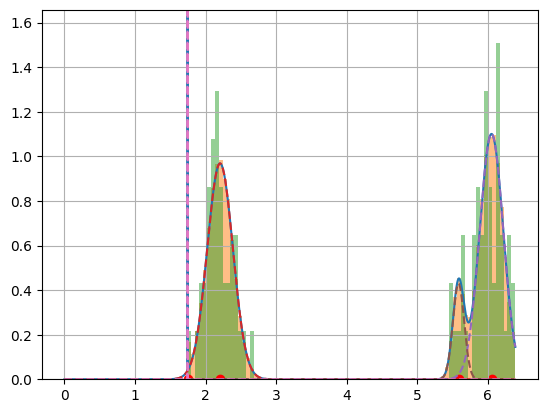

(0.023158228796256206, 130.06540590001612)
---


In [8]:
for i in range(1, 5):
    print(i)
    gmm_pre_noon = GMM(train[train['after_noon'] == 0], i)
    gmm_pre_noon.plot_gmm()
    print(gmm_pre_noon.goodness())
    print('---')

1


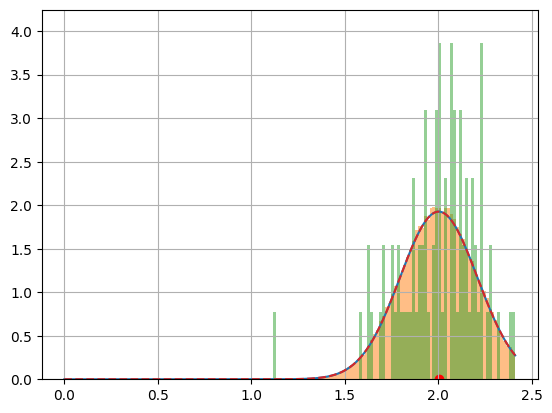

(0.02598351699083056, -16.720077099154672)
---
2


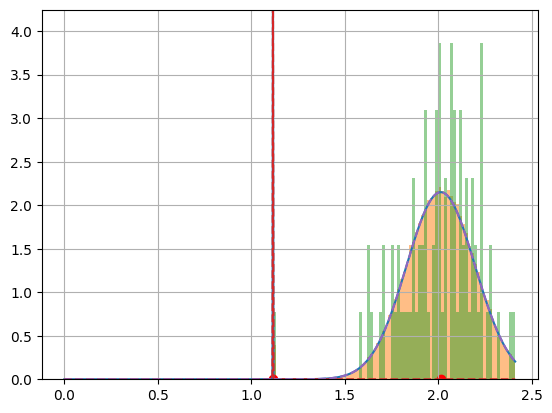

(0.017590742334073674, -24.137412014686127)
---
3


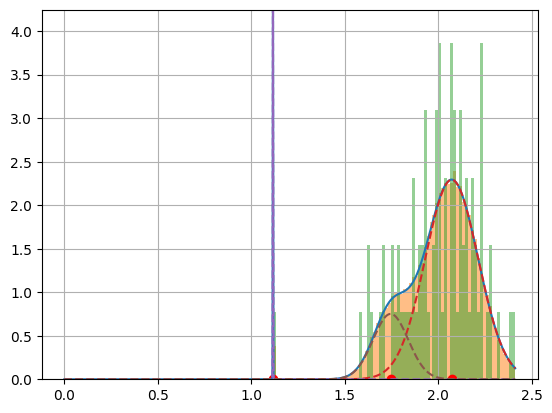

(0.00836159411322677, -14.87441038194406)
---
4


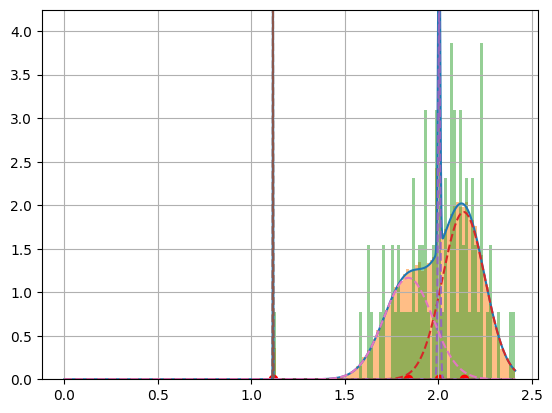

(0.008374411166921702, -6.023144517691158)
---


In [9]:
for i in range(1, 5):
    print(i)
    gmm_pre_noon = GMM(train[train['after_noon'] == 1], i)
    gmm_pre_noon.plot_gmm()
    print(gmm_pre_noon.goodness())
    print('---')

1


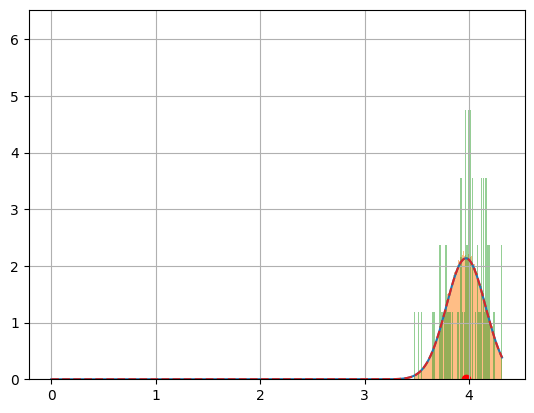

(0.02931033303751828, -29.650187067786995)
---
2


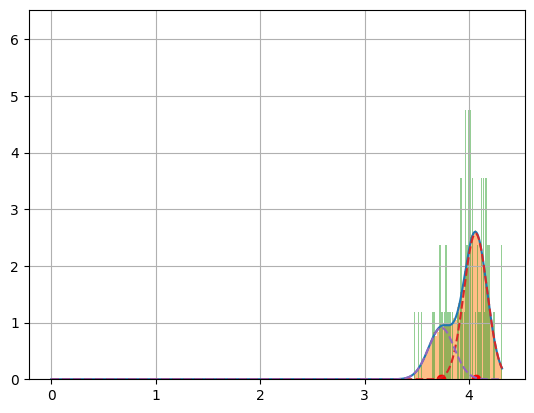

(0.016717199351061637, -24.98219656924639)
---
3


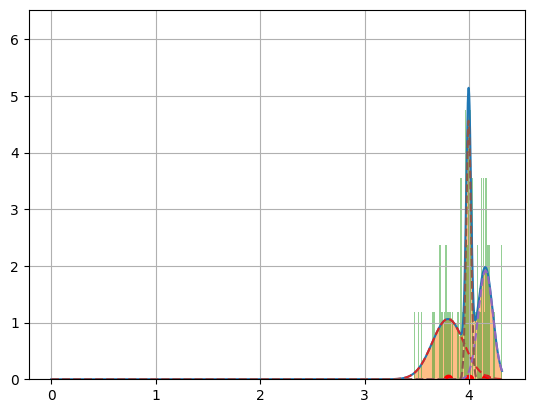

(0.01006711740574118, -24.94594039912507)
---
4


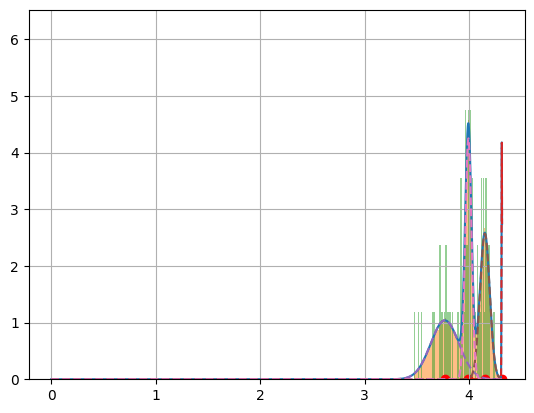

(0.008606077561270544, -23.042974170666184)
---


In [10]:
for i in range(1, 5):
    print(i)
    gmm_pre_noon = GMM(train[train['after_noon'] == 2], i)
    gmm_pre_noon.plot_gmm()
    print(gmm_pre_noon.goodness())
    print('---')

1


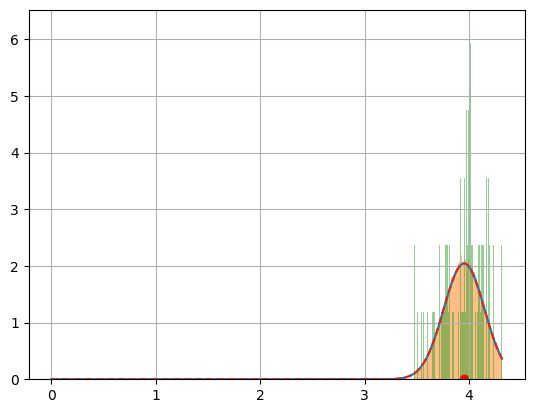

(0.03001995669342549, -25.564721229820783)
---
2


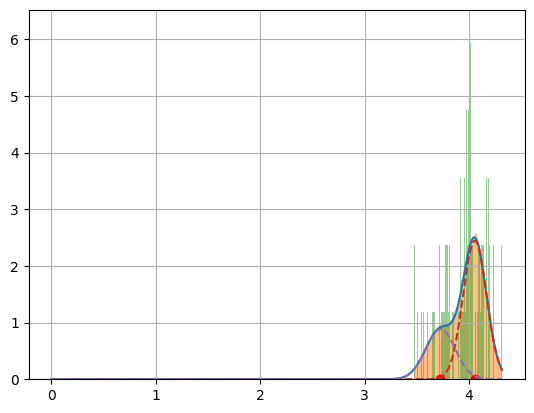

(0.015881436138536504, -21.88211968555805)
---
3


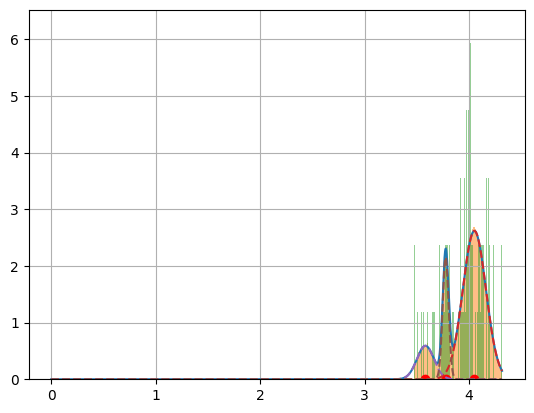

(0.01267463246517844, -18.623442772060457)
---
4


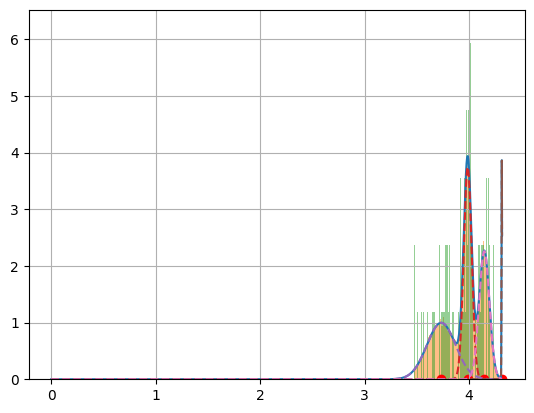

(0.01070591719807276, -16.13077680736525)
---


In [11]:
for i in range(1, 5):
    print(i)
    gmm_pre_noon = GMM(train[train['after_noon'] == 3], i)
    gmm_pre_noon.plot_gmm()
    print(gmm_pre_noon.goodness())
    print('---')

In [12]:
gmm_pre_noon = GMM(train[train['after_noon'] == False], 2)
gmm_after_noon = GMM(train[train['after_noon'] == True], 1)

